In [96]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import warnings
import pandas as pd

style.use("seaborn-white")
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [2]:
# search functions from task_2
def golden_section(f, f_range=(0,1), eps=0.001):
    delta = (3 - np.sqrt(5)) / 2
    f_calculations = 0
    a, b = f_range
    x1, x2 = a + delta * (b-a), b - delta * (b-a)
    f_x1, f_x2 = f(x1), f(x2)
    f_calculations += 2
    iters = 0
    while abs(a-b) >= eps:
        if f_x1 <= f_x2:
            b = x2
            x2 = x1
            x1 = a + delta * (b-a)
            f_x2 = f_x1
            f_x1 = f(x1)
        else:
            a = x1
            x1 = x2
            x2 = b - delta * (b-a)
            f_x1 = f_x2
            f_x2 = f(x2)
        f_calculations += 1
        iters += 1
    return (a+b) / 2, f((a+b) / 2), f_calculations + 1, iters

# 2d search methods
def exhaustive_2d_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    f_min = np.inf
    f_calculations = 0
    best_params = None
    iters = 0
    for i in np.arange(f_range_1[0], f_range_1[1], eps):
        for j in np.arange(f_range_2[0], f_range_2[1], eps):
            cur_loss = loss(f, x, i, j, y_true)
            if f_min > cur_loss:
                f_min = cur_loss
                best_params = (i, j)
            f_calculations += 1
            iters += 1
    return best_params[0], best_params[1], f_min, f_calculations, iters

def gauss_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    a, b = 0.5, 0.5
    loss_prev = loss(f, x, a, b, y_true)
    min_loss = np.inf
    f_calculations = 1
    iters = 0
    while abs(min_loss - loss_prev) >= eps:
        loss_prev = min_loss
        
        # 'a' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=t, b=b, y_true=y_true)
        a_opt, min_loss, a_calculations, a_iters = golden_section(opt_fn, f_range_1, eps=eps)
        a_prev = a
        a = a_opt
        
        # 'b' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=a, b=t, y_true=y_true)
        b_opt, min_loss, b_calculations, b_iters = golden_section(opt_fn, f_range_2, eps=eps)
        b_prev = b
        b = b_opt
        
        f_calculations += a_calculations + b_calculations
        iters += a_iters + b_iters
    return a, b, min_loss, f_calculations, iters

def nelder_mead(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    opt_fn = lambda t: loss(f, x=x, a=t[0], b=t[1], y_true=y_true)
    a0, b0 = 0.5, 0.5
    result = optimize.minimize(opt_fn, x0=[a0, b0], method="Nelder-Mead", 
                               bounds=[f_range_1, f_range_2], 
                               options={"xatol": eps, "fatol": eps}
    )
    return result.x[0], result.x[1], result.fun, result.nfev, result.nit

In [97]:
# gradient optimization methods
def gradient_descent(f_name, x, y_true, lr=1e-3, eps=0.001, max_iters=10000):
    a, b = 0.5, 0.5
    grad_a, grad_b = np.inf, np.inf
    iters = 0
    f_calculations = 0
    grad_calculations = 0
    while np.abs(grad_a) > eps and np.abs(grad_b) > eps and iters < max_iters:
        grad_l_f = loss_grad(eval(f_name), x, a, b, y_true)
        grad_f_a, grad_f_b = eval(f"{f_name}_grad")(x, a, b)
        grad_a, grad_b = np.sum(grad_l_f * grad_f_a), np.sum(grad_l_f * grad_f_b)
        a -= grad_a * lr
        b -= grad_b * lr
        cur_loss = loss(eval(f_name), x, a, b, y_true)
        iters += 1
        f_calculations += 2
        grad_calculations += 1
    return a, b, cur_loss, f_calculations, grad_calculations, iters

def conj_gradient_descent(f_name, x, y_true, eps=0.001, max_iters=10000):
    a, b = 0.5, 0.5
    def func(params):
        return loss(eval(f_name), x, a=params[0], b=params[1], y_true=y_true)

    def func_grad(params):
        grad_l_f = loss_grad(eval(f_name), x, a=params[0], b=params[1], y_true=y_true)
        grad_f_a, grad_f_b = eval(f"{f_name}_grad")(x, a=params[0], b=params[1])
        grad_a, grad_b = np.sum(grad_l_f * grad_f_a), np.sum(grad_l_f * grad_f_b)
        return np.array((grad_a, grad_b))

    result = optimize.fmin_cg(
        func, x0=[a, b], fprime=func_grad, gtol=eps, 
        maxiter=max_iters, full_output=True, retall=True
    )
    return result[0][0], result[0][1], result[1], result[2], result[3], len(result[5])


def newton(f_name, x, y_true, eps=0.001, max_iters=10000):
    a, b = 0.5, 0.5
    def func(params):
        return loss(eval(f_name), x, a=params[0], b=params[1], y_true=y_true)

    def func_grad(params):
        grad_l_f = loss_grad(eval(f_name), x, a=params[0], b=params[1], y_true=y_true)
        grad_f_a, grad_f_b = eval(f"{f_name}_grad")(x, a=params[0], b=params[1])
        grad_a, grad_b = np.sum(grad_l_f * grad_f_a), np.sum(grad_l_f * grad_f_b)
        return np.array((grad_a, grad_b))

    result = optimize.minimize(
        func, x0=[a, b], jac=func_grad, method='Newton-CG', 
        options={"xtol": eps, "maxiter": max_iters}
    )

    return result.x[0], result.x[1], result.fun, result.nfev, result.njev, result.nit


def levenberg_marquardt(f_name, x, y_true, eps=0.001, max_iters=10000):
    a, b = 0.5, 0.5
    def func(params):
        return eval(f_name)(x, params[0], params[1]) - y_true

    def func_grad(params):
        grad_f_a, grad_f_b = eval(f"{f_name}_grad")(x, a=params[0], b=params[1])
        return np.vstack([grad_f_a, grad_f_b]).T

    result = optimize.least_squares(
        func, x0=[a, b], jac=func_grad, method="lm", xtol=eps, max_nfev=max_iters
    )
    return result.x[0], result.x[1], result.cost * 2, result.nfev, result.njev, result.nfev

In [4]:
def get_noisy_data():
    alpha, beta = np.random.uniform(size=2)
    x = np.arange(0, 1, 0.01)
    y = alpha * x + beta + np.random.normal(size=x.shape)
    return np.array([x, y])

def loss(f, x, a, b, y_true):
    return np.sum((f(x, a, b) - y_true) ** 2)

def loss_grad(f, x, a, b, y_true):
    return 2 * (f(x, a, b) - y_true)

def linear(x, a, b):
    return a * x + b

def linear_grad(x, a, b):
    return x, np.ones_like(x)

def rational(x, a, b):
    return a / (1 + b * x)

def rational_grad(x, a, b):
    return 1 / (1 + b * x), -a * x / (1 + b * x) ** 2

In [122]:
searches_2d = (exhaustive_2d_search, gauss_search, nelder_mead)
gradient_searches = (gradient_descent, conj_gradient_descent, newton, levenberg_marquardt)

In [120]:
def search_2d_and_plot(f, data, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    results_calculations = dict()
    results_iters = dict()
    results_grads = dict()
    _, axes = plt.subplots(nrows=3, figsize=(25, 30))
    axes[0].scatter(data[0], data[1], label='data', c='b')
    axes[0].title.set_text(f"Searches results for {f.__name__} approximant")
    for search in searches_2d:
        best_a, best_b, f_min, f_calculations, iters = search(
            f=f, x=data[0], y_true=data[1], f_range_1=f_range_1, f_range_2=f_range_2, eps=eps
        )
        label = f'{search.__name__}, min_loss={round(f_min, 2)}'
        axes[0].plot(data[0], f(data[0], best_a, best_b), label=label, linewidth=2)
        results_calculations[search.__name__] = f_calculations
        results_iters[search.__name__] = iters
    
    for search in gradient_searches:
        best_a, best_b, f_min, f_calculations, grad_calculations, iters = search(
            f_name=f.__name__, x=data[0], y_true=data[1], eps=eps
        )
        label = f'{search.__name__}, min_loss={round(f_min, 2)}'
        axes[0].plot(data[0], f(data[0], best_a, best_b), label=label, linewidth=2)
        results_calculations[search.__name__] = f_calculations
        results_iters[search.__name__] = iters
        results_grads[search.__name__] = grad_calculations
    
    to_plot = pd.DataFrame(zip(
        np.array([[s.__name__]*2 for s in searches_2d+gradient_searches]).flatten(), 
        ['iterations', 'f_calculations']*len(searches_2d+gradient_searches),
        np.array([[results_iters[k], results_calculations[k]] for k in results_iters]).flatten()
    ), columns=("methods", "metric", "result"))
    sns.barplot(x="methods", hue="metric", y="result", data=to_plot, ax=axes[1], log=True)
    
    axes[0].legend()
    axes[1].title.set_text(f"Searches metrics for {f.__name__} approximant")
    axes[2].bar(results_grads.keys(), results_grads.values(), log=True)
    axes[2].title.set_text(f"Searches number of gradient calculations for {f.__name__} approximant")

In [112]:
data = get_noisy_data()

Optimization terminated successfully.
         Current function value: 102.328548
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


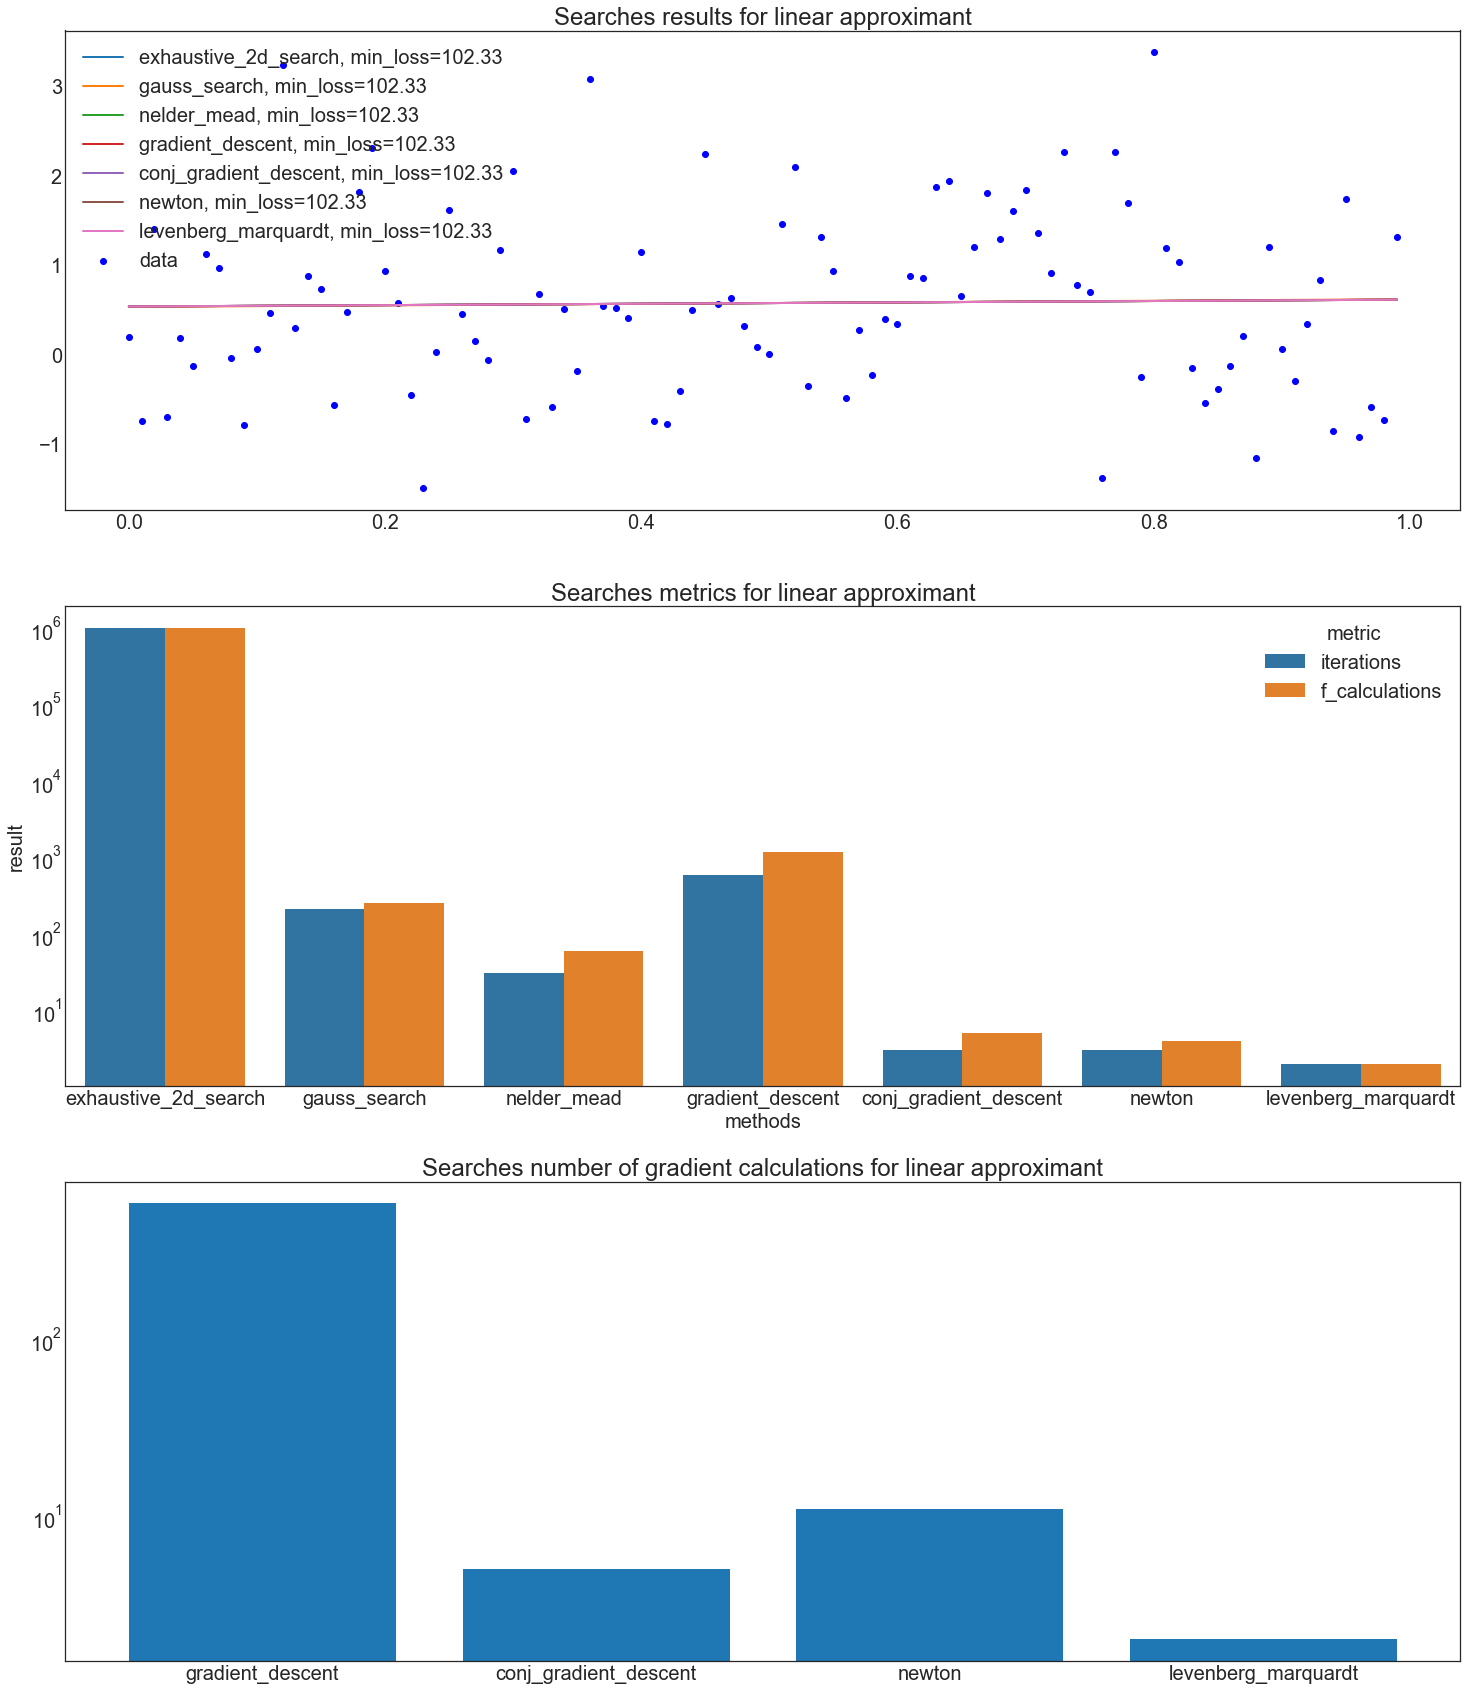

In [123]:
search_2d_and_plot(linear, data)

Optimization terminated successfully.
         Current function value: 102.347562
         Iterations: 11
         Function evaluations: 29
         Gradient evaluations: 29


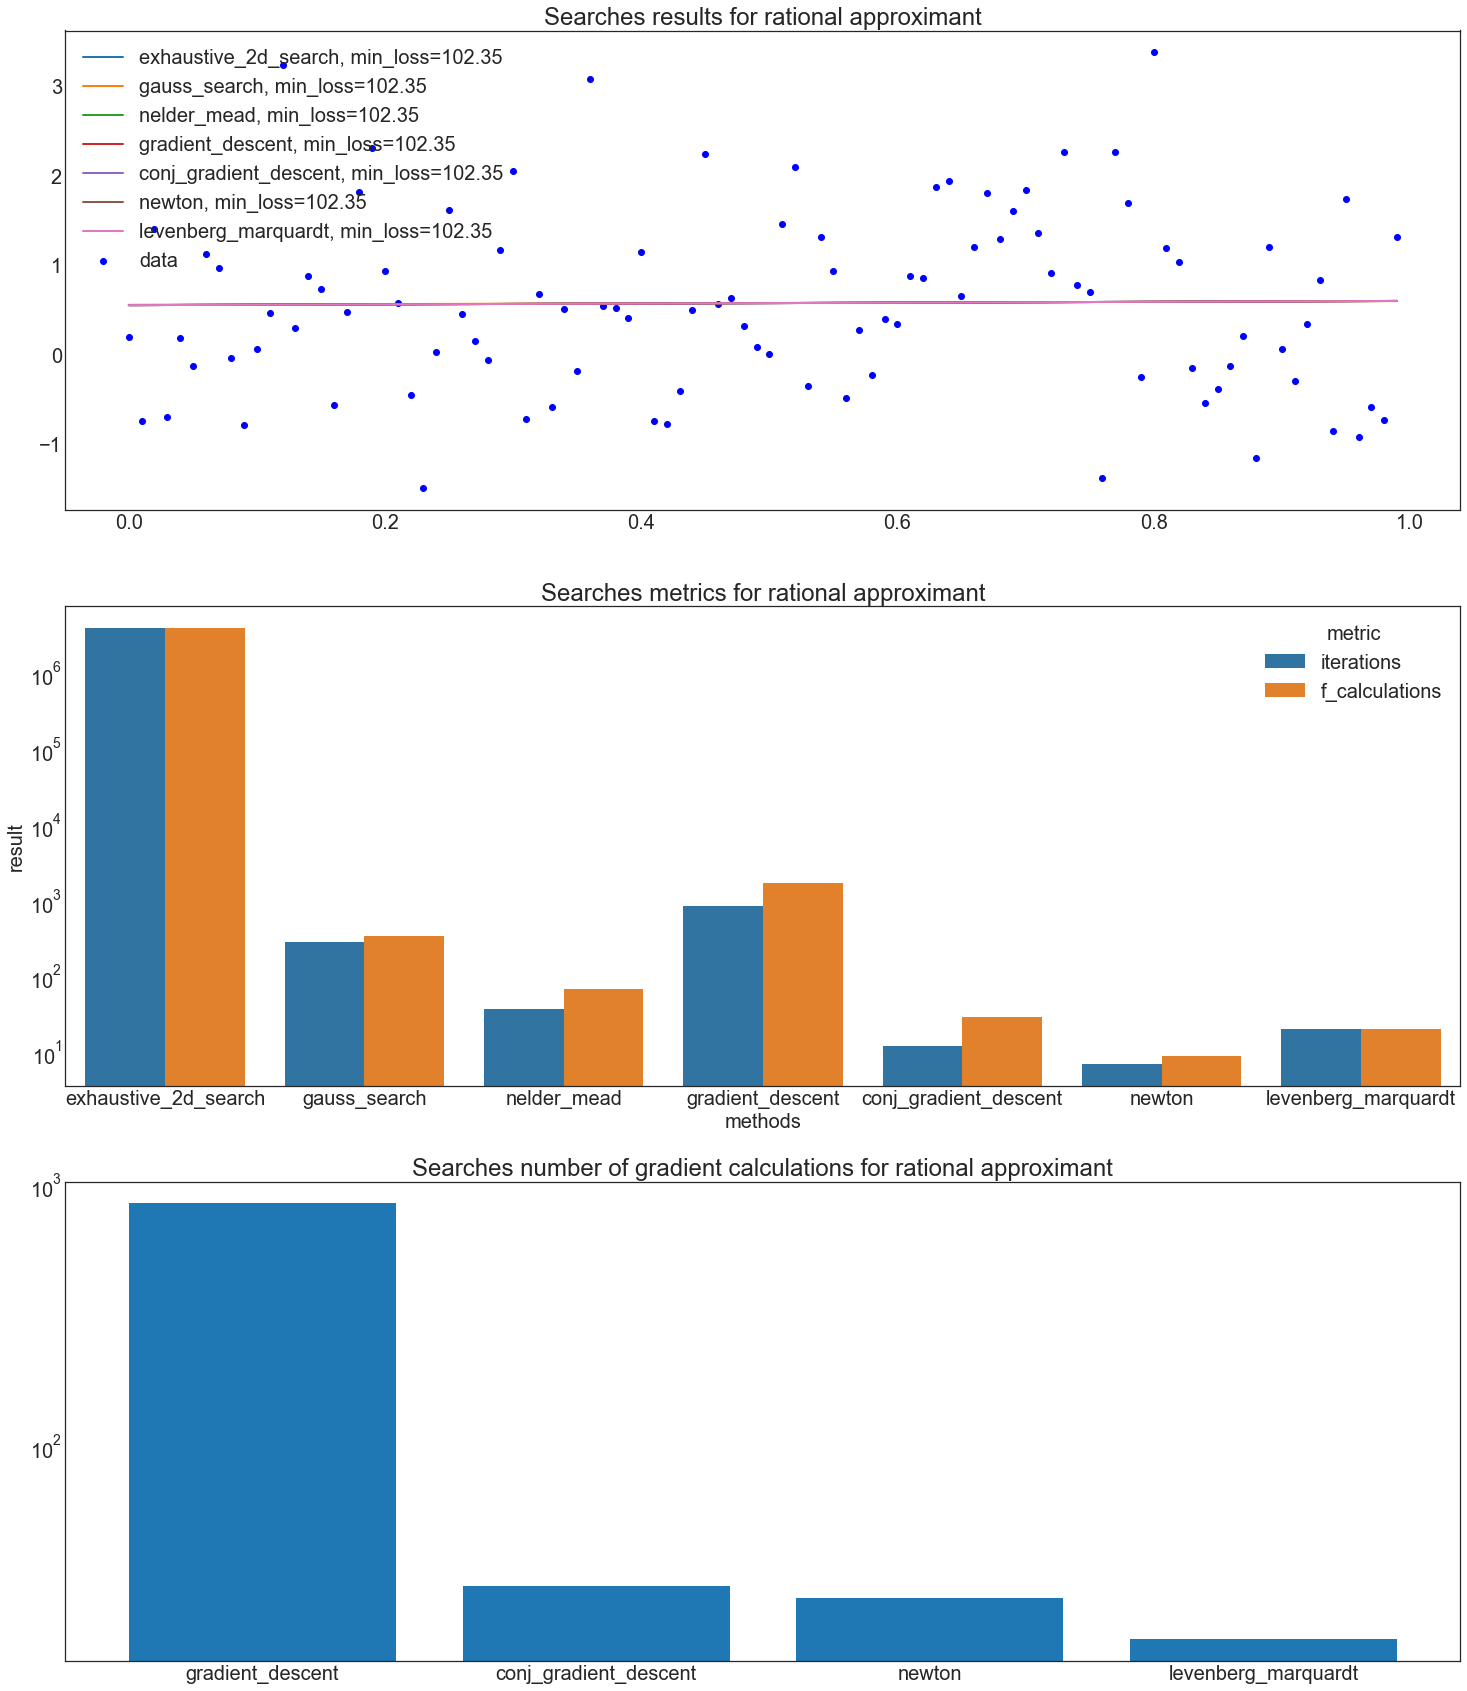

In [124]:
search_2d_and_plot(rational, data, f_range_1=(-1,1), f_range_2=(-1,1))